## 1. Foreword

Your problem statement will be the guiding force that will influence every question and decision making from this point onward. Before starting any of the exercises get that down.

It would be helpful to refresh the basics of statistical modelling and machine learnin before proceeding, here are the essential concepts that you should understand:

1. Exploratory Data Analysis (EDA):
    - Descriptive statistics (mean, median, variance, quantiles)
    - Understanding distributions and variability 

2. Data Pre-processing
    - Features & Target Transformation
    - Creating new features
    - Feature Selection

3. Regression Models: Linear Regression, Regularized Regression (Ridge, Lasso)
    - Interpreting coefficients, understanding R², MSE, MAE, RMSE

4. Classification Models: Logistic Regression, Decision Trees, Random Forests, SVMs, K-Nearest Neighbors
    - Interpreting probabilities, coefficients (log-odds), and feature importances

5. Evaluation Metrics:
    - For Regression: R², Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE)
    - For Classification: Accuracy, Precision, Recall, F1 Score, ROC-AUC, and Confusion Matrix

6. Model Selection & Validation:
    - Train-test splits, cross-validation techniques
    - Overfitting vs. underfitting
    - Hyperparameter tuning (grid search, random search)

7. Model Interpretability & Explainability:
    - Interpreting model coefficients and feature importance
    - Visualization of decision trees (using plot_tree)
    - Tools like SHAP and LIME for local/global explanations



#### The entire Data Science process would look something like:

1. Exploration: Start with EDA to understand your data. Ask questions about distributions, correlations, and anomalies.
2. Modeling:Build models using core algorithms, evaluate with relevant metrics, and examine model outputs (coefficients, feature importances).
3. Evaluation:Compare metrics against baselines, inspect errors, and assess whether the model meets the problem requirements.
4. Iteration:Use insights from the evaluation to refine feature engineering, adjust preprocessing steps, or try different models.
5. Repeat: Go through this process again—exploration, modeling, evaluation—until you reach the desired balance between performance, interpretability, and practical applicability, based on your problem statement


## 2. Assignment Tasks

1) Define a problem statement
2) Perform EDA (if you are choosing a new dataset)
3) Use EDA Insights for feature selection and feature engineering
4) Create your first 3 models using the framework I provide
5) Evaluate the model and then attempt to improve it
6) Interpret Model results and outputs (coefficients, trees) and continue to add to your insights.
7) Explore 2 new models of your choice. Some suggestions are KNN, SVM for classification & Ridge, Lasso for regression but there are so many more and part of the fun of data science is researching new ways to do things.


Please note that the tasks above are guidelines and this is more of an art than a science. Your specific problem might require some specialized techniques and steps. I implore you to question every characteristic of your dataset and models you encounter and ask "how can I use this to give me insights?" and "what technique can I apply to this to make it useful?".

Good luck and feel free to reach out with any questions.

## 3. Resources
1. Concise explanation for popular Machine learning models : https://www.youtube.com/watch?v=E0Hmnixke2g 
2. Fantastic sklearn algorithms cheat sheet : https://scikit-learn.org/stable/machine_learning_map.html
    - This sklearn tutorial by the sklearn team is amazing too : https://scikit-learn.org/1.4/tutorial/index.html
3. The Python Data Science handbook I linked last assignment has a great machine learning section that should help clear any basics.

These should help you get started but the best way to learn is start the process and when you encounter something you don't fully understand, look that up specifically and apply it. 

## 4. Predictive Modelling (Your Assignment Should be Below)

For reference, below is working code roughly following the guidelines and using the same dataset from the last couple sessions.

### Cleaning & Pre-Processing

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
from sklearn import datasets

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# For combining pipelines after encoding
from sklearn.compose import make_column_selector as selector

sns.set(style="whitegrid")

In [26]:
adult_income_dataset = fetch_ucirepo(id=2) 
# data (as pandas dataframes) 
df = adult_income_dataset.data.original

Some Basic Cleaning

In [27]:
df.columns = df.columns.str.replace("-","_")
df.loc[df.income == '<=50K.','income'] = '<=50K'
df.loc[df.income == '>50K.','income'] = '>50K'

Generating Continuous Data to use regression

In [28]:
# Generating a continuous income variable based on 
median_education = df['education_num'].median()

def generate_continuous_income(row):
    # Base assumptions for each income bracket
    if row['income'] == '<=50K':
         base = 35000
         std = 6000  # Assumed standard deviation for <=50K group
    else:
         base = 75000
         std = 15000  # Assumed standard deviation for >50K group

    # Adjustment based on education: each level above/below the median adds/subtracts $2,000
    edu_adjustment = (row['education_num'] - median_education) * 2000

    # Adjustment based on age: each year above 40 adds $500 (or subtracts if below 40)
    age_adjustment = (row['age'] - 40) * 500

    # Combine base value with adjustments and then add random noise based on the standard deviation
    income_value = int(round(np.random.normal(base + edu_adjustment + age_adjustment, std),-2))
    return income_value

# Create the new continuous income column
df['continuous_income'] = df.apply(generate_continuous_income, axis=1)

- Missing occupation, likely unemployed or self-emplployed? 
- missing workclass : likely the same set? 
- missing native country : could be bi-racial or just missing in the survey/input methodology

choosing to keep the missing values

In [29]:
df.fillna('?',inplace=True)

In [30]:
#income is skewed, so we will log transform it
df["continuous_income"] = np.log1p(df["continuous_income"])
df.fillna(0, inplace = True) #log transform might create nan values

c:\Users\praty\OneDrive\Desktop\Build Fellowship\build_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
#converting binary target into integer
df["income"] = df["income"].map({">50K": 1, "<=50K": 0})

In [47]:
target_cols = ["income","continuous_income"]
features = [col for col in df.columns if col not in target_cols]

cat_features = [col for col in features if df[col].dtype == "object"]
num_features = [col for col in features if df[col].dtype != "object"]

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ],
    sparse_threshold=0
)

X_processed = preprocessor.fit_transform(df[features])
new_feature_names = (
    num_features + 
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features))
)
df_transformed = pd.DataFrame(X_processed, columns=new_feature_names)

print(df_transformed.head())

    age    fnlwgt  education_num  capital_gain  capital_loss  hours_per_week  \
0  0.10 -0.837932       1.000000        2174.0           0.0             0.0   
1  0.65 -0.789677       1.000000           0.0           0.0            -5.4   
2  0.05  0.312274      -0.333333           0.0           0.0             0.0   
3  0.80  0.471112      -1.000000           0.0           0.0             0.0   
4 -0.45  1.334520       1.000000           0.0           0.0             0.0   

   workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0          0.0                    0.0                  0.0   
1          0.0                    0.0                  0.0   
2          0.0                    0.0                  0.0   
3          0.0                    0.0                  0.0   
4          0.0                    0.0                  0.0   

   workclass_Never-worked  ...  native_country_Portugal  \
0                     0.0  ...                      0.0   
1                     0.0  .

In [48]:
# Split features and targets
X_processed = df_transformed

y_class = df["income"].astype(int)  # Ensure binary target is integer (0/1)
y_reg = df["continuous_income"]

# Split into training and test sets (70/30 split)
# we are using the same training set but distinct targets for the classification & regression models
X_train, X_test, y_class_train, y_class_test = train_test_split(X_processed, y_class, test_size=0.3, random_state=42)
_, _, y_reg_train, y_reg_test = train_test_split(X_processed, y_reg, test_size=0.3, random_state=42)


### A. Regression Models

In [49]:
# --- Linear Regression ---
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_reg_train)
y_pred_lin = lin_reg.predict(X_test)
r2_lin = r2_score(y_reg_test, y_pred_lin)
mse_lin = mean_squared_error(y_reg_test, y_pred_lin)
mae_lin = mean_absolute_error(y_reg_test, y_pred_lin)

print("Linear Regression R²:", r2_lin, "MSE:", mse_lin, "MAE:", mae_lin)

Linear Regression R²: 0.5339472178677455 MSE: 0.13934281700055737 MAE: 0.2628783441638396


In [50]:

# --- Decision Tree Regressor ---
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_reg_train)
y_pred_dt = dt_reg.predict(X_test)
r2_dt = r2_score(y_reg_test, y_pred_dt)
mse_dt = mean_squared_error(y_reg_test, y_pred_dt)
print("Decision Tree Regressor R²:", r2_dt, "MSE:", mse_dt)

Decision Tree Regressor R²: 0.15698722935969933 MSE: 0.2520482201415756


In [51]:
rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)
rf_reg.fit(X_train, y_reg_train)
y_pred_rf = rf_reg.predict(X_test)
r2_rf = r2_score(y_reg_test, y_pred_rf)
mse_rf = mean_squared_error(y_reg_test, y_pred_rf)
print("Random Forest Regressor R²:", r2_rf, "MSE:", mse_rf)

Random Forest Regressor R²: 0.4936031485848388 MSE: 0.15140509080016012


### B. Classification Models


Logistic Regression Accuracy: 0.8491776428035215


c:\Users\praty\OneDrive\Desktop\Build Fellowship\build_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


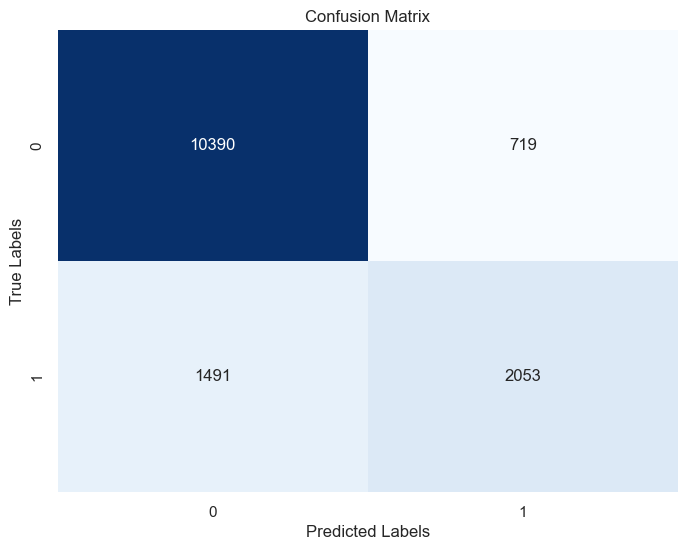

Precision: 0.7406204906204906
Recall: 0.5792889390519187
F1-Score: 0.6500949968334389


In [52]:
# --- Logistic Regression for Classification ---
log_reg = LogisticRegression(max_iter=1000)


log_reg.fit(X_train, y_class_train)
y_pred_log = log_reg.predict(X_test)

acc_log = accuracy_score(y_class_test, y_pred_log)
print("Logistic Regression Accuracy:", acc_log)

cm =  confusion_matrix(y_class_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


precision = precision_score(y_class_test, y_pred_log)
recall = recall_score(y_class_test, y_pred_log)
f1 = f1_score(y_class_test, y_pred_log)
##roc_auc = roc_auc_score(y_class_test, y_prob_class)  # Typically y_prob_class[:,1] if using predict_proba

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
#print("ROC-AUC:", roc_auc)


In [59]:
# --- Decision Tree Classifier ---
dt_clf = DecisionTreeClassifier(random_state=50,max_depth=5)
dt_clf.fit(X_train, y_class_train)
y_pred_dt_clf = dt_clf.predict(X_test)
acc_dt_clf = accuracy_score(y_class_test, y_pred_dt_clf)
print("Decision Tree Classifier Accuracy:", acc_dt_clf)
print("Confusion Matrix:\n", confusion_matrix(y_class_test, y_pred_dt_clf))

Decision Tree Classifier Accuracy: 0.8497236060874906
Confusion Matrix:
 [[10598   511]
 [ 1691  1853]]


In [54]:
# --- Random Forest Classifier ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_class_train)
y_pred_rf_clf = rf_clf.predict(X_test)
acc_rf_clf = accuracy_score(y_class_test, y_pred_rf_clf)
print("Random Forest Classifier Accuracy:", acc_rf_clf)
print("Confusion Matrix:\n", confusion_matrix(y_class_test, y_pred_rf_clf))

Random Forest Classifier Accuracy: 0.8538183307172592
Confusion Matrix:
 [[10320   789]
 [ 1353  2191]]


### C. Interpreting Results

#### Regression Coefficients

In [55]:
### Getting Regression Coefficients
coefficients = lin_reg.coef_
coef_series = pd.Series(coefficients, index=X_train.columns)
print("Regression Coefficients:")
print(coef_series.sort_values(ascending=False))

Regression Coefficients:
age                               0.315799
education_num                     0.269328
relationship_Wife                 0.138169
native_country_Portugal           0.133705
native_country_Yugoslavia         0.115086
                                    ...   
occupation_Farming-fishing       -0.099775
native_country_Trinadad&Tobago   -0.106371
native_country_Mexico            -0.106964
native_country_Laos              -0.256379
education_Preschool              -0.327830
Length: 108, dtype: float64


The coefficients are interpreted as "the change in the target associated with a unit change in that variable, if all else remains the same". 
- A higher positive value means the feature has a strong positive association with the target.
- A negative value means the feature is inversely associated with the target.
- This helps in understanding which predictors have the most influence on your continuous target variable.

#### Log Odds for Logistic Regression

In [57]:
log_odds = log_reg.coef_  # This returns a 2D array (for binary classification, shape is (1, n_features))
log_odds_series = pd.Series(log_odds[0], index=X_train.columns)
print("Logistic Regression Log Odds:")
print(log_odds_series.sort_values(ascending=False))

Logistic Regression Log Odds:
relationship_Wife                    1.127663
marital_status_Married-civ-spouse    1.011478
education_num                        0.835023
occupation_Exec-managerial           0.679784
age                                  0.496615
                                       ...   
occupation_Farming-fishing          -0.861014
occupation_Other-service            -0.900050
marital_status_Never-married        -1.015513
relationship_Own-child              -1.049441
sex_Female                          -1.077663
Length: 108, dtype: float64


The sign and magnitude of each log-odds coefficient indicate how a one-unit change in the feature affects the log odds of being in the positive class.

#### Visualizing a Decision Tree

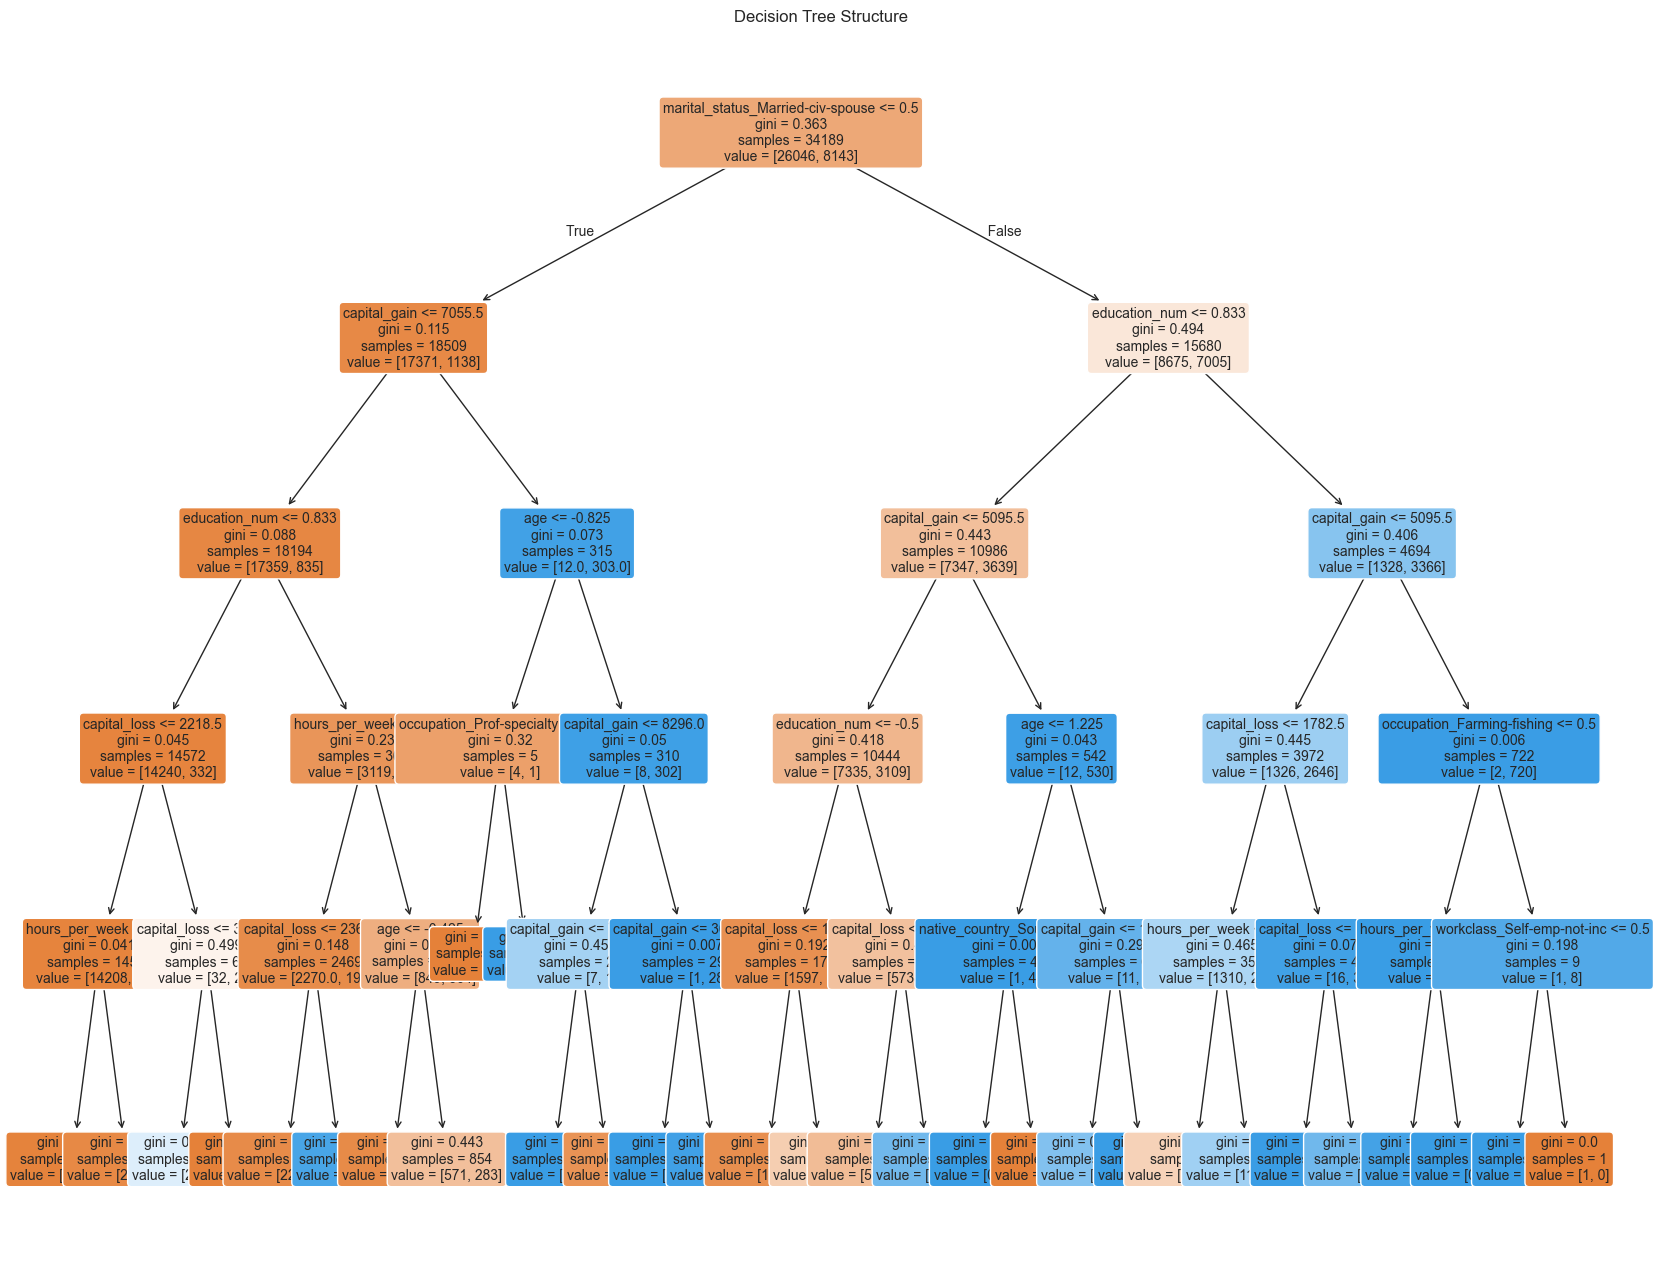

In [61]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 16))
plot_tree(dt_clf, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

I personally find this fascinating to look at. You can directly see how the tree will look at an observation and make a decision about which class it should put that in.

The trees get harder to look at the more you increase the max_depth hyperparameter, so its a balancing act between model performance and interpretability.

#### Hyperparameter Tuning 

We will use Grid Search CV that has cross-validation built in and will help us compare model performance accross different hyperparameters to choose the best one.

It would be really productive if you try to understand what the hyperparameters mean and how they will be helpful for your problem and make educated guesses about which ones to test with gridSearch. 

In [68]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid. You can play around with different grids or make a giant one with a lot of numbers.

param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criteria
    'max_depth': [None, 5, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],       # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}


# Assume rf_reg is your RandomForestRegressor instance
grid_search = GridSearchCV(estimator= dt_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_class_train)


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validated accuracy:", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Cross-Validated accuracy: 0.8592821572039993


In [69]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Display selected columns, e.g., parameters and mean test score
results_df[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.817281,0.004963
1,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.822516,0.002353
2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.827605,0.003792
3,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.827518,0.004310
4,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.827430,0.003551
...,...,...,...
211,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.834215,0.008385
212,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.832929,0.008245
213,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.830326,0.002083
214,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.830326,0.002083
